# Supernova distances and redshifts

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a Nobel prize plot by Riess et al.

![Riess_et_al](Riess_et_al.jpg)

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$\mu = m - M = 5 \log_{10} \left( \frac{d_L}{pc} \right) - 5$$
 
Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import get_cmap

from astroML.datasets import generate_mu_z

from sklearn.linear_model import LinearRegression as sklearn_LR

from astroML.linear_model import LinearRegression as astroML_LR
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

from astropy.cosmology import LambdaCDM

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/home/alessia_pozzi/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Data import

In [368]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

x_grid = np.linspace(0, 2, 1000)

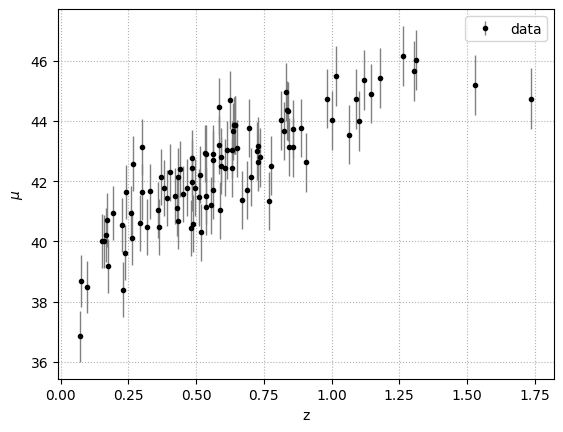

In [369]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.legend()
plt.grid(linestyle=':')
plt.show()

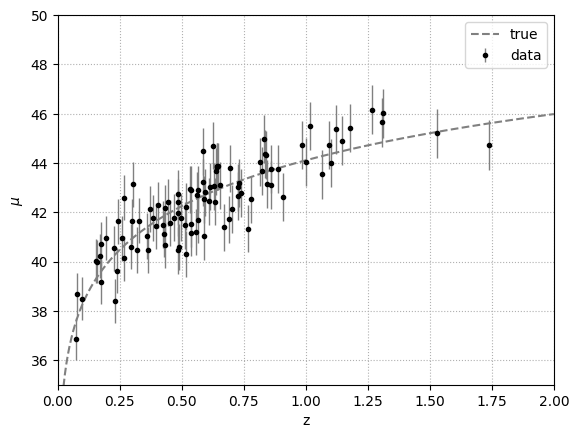

In [407]:
# True distribution
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, '--', c='gray',label='true')
plt.xlim(0,2)
plt.ylim(35,50)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Part 1

**Task**

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

**OPTIONAL**

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

### Regression Algorithms

#### Linear Regression

In [ ]:
# Using sklearn.linear_model.LinearRegression
lin_reg_sklearn = sklearn_LR()
lin_reg_sklearn.fit(z_sample[:, np.newaxis], mu_sample, sample_weight=1.0)

y_pred_sklearn = lin_reg_sklearn.predict(x_grid[:, np.newaxis])

print("model: y = theta_0 + theta_1 ⋅ x")
print(f"theta_0 = {lin_reg_sklearn.intercept_:.3f} ; theta_1 = {lin_reg_sklearn.coef_[0]:.3f}")

model: y = theta_0 + theta_1 ⋅ x
theta_0 = 39.565 ; theta_1 = 4.647


In [ ]:
# Using astroML.linear_model.LinearRegression
lin_reg_astroML = astroML_LR()
lin_reg_astroML.fit(z_sample[:, np.newaxis], mu_sample, dmu)

print("model: y = theta_0 + theta_1 ⋅ x")
print(f"theta_0 = {lin_reg_astroML.coef_[0]:.3f} ; theta_1 = {lin_reg_astroML.coef_[1]:.3f}")

y_pred_astroML = lin_reg_astroML.predict(x_grid[:, np.newaxis])

model: y = theta_0 + theta_1 ⋅ x
theta_0 = 39.484 ; theta_1 = 4.764


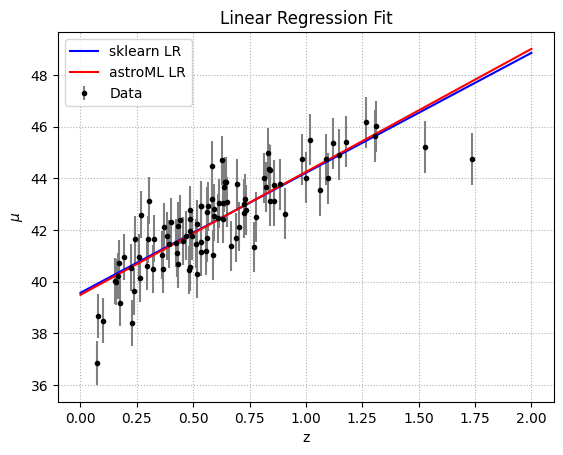

In [ ]:
# Comparison plot
plt.errorbar(z_sample, mu_sample, dmu, fmt="k.", ecolor='gray', label='Data')
plt.plot(x_grid, y_pred_sklearn, color='b', label='sklearn LR')
plt.plot(x_grid, y_pred_astroML, color='r', label='astroML LR')
plt.title("Linear Regression Fit")
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend()
plt.grid(linestyle=':')
plt.show()

The two methods return the same fit.

But, the linear regression clearly underfits the data. The curve is too simple to capture the non-linear relationship between redshift and distance modulus seen in cosmological data.

#### Polinomial Regression

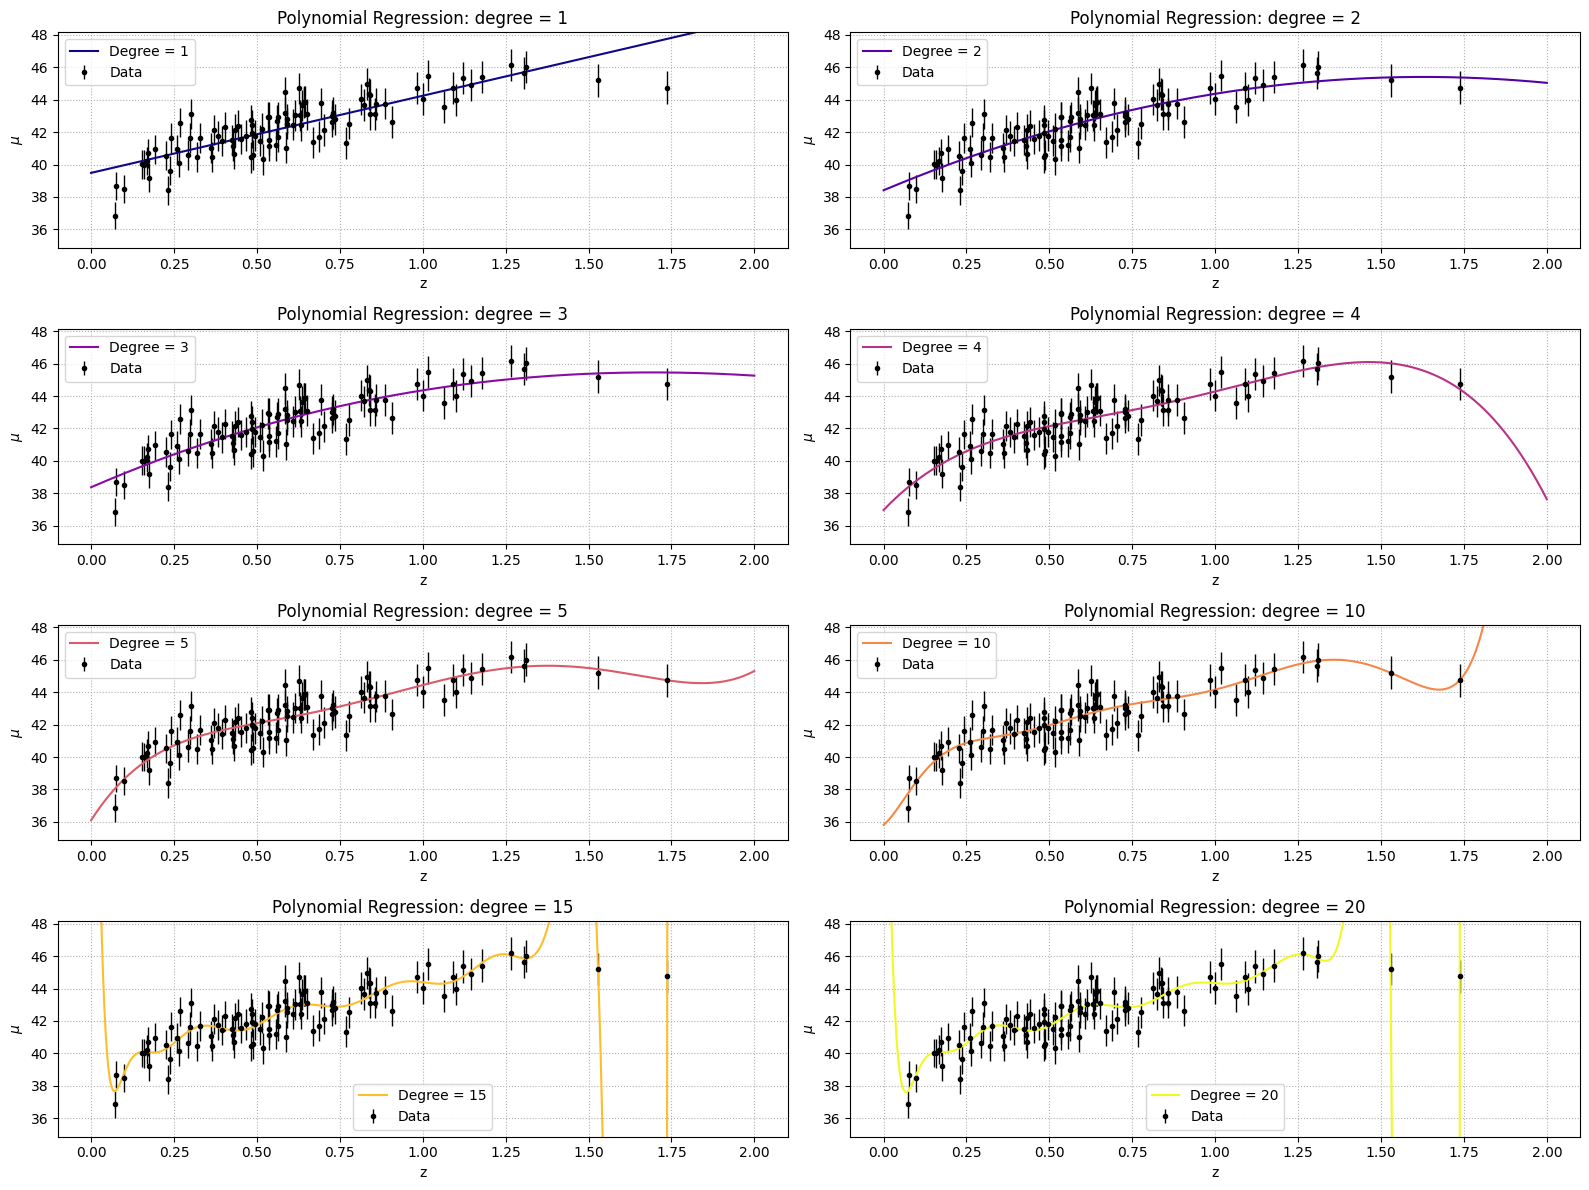

In [ ]:
degrees = [1, 2, 3, 4, 5, 10, 15, 20]
colors = get_cmap('plasma')(np.linspace(0, 1, len(degrees)))

plt.figure(figsize=(16, 12))

for i, (degree, color) in enumerate(zip(degrees, colors), 1):
    pol_reg = PolynomialRegression(degree)
    pol_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    y_pred_pol = pol_reg.predict(x_grid[:, np.newaxis])
    
    plt.subplot(4, 2, i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', lw=1, label='Data')
    plt.plot(x_grid, y_pred_pol, color=color, label=f'Degree = {degree}')
    plt.ylim(np.min(mu_sample) - 2, np.max(mu_sample) + 2)
    plt.title(f"Polynomial Regression: degree = {degree}")
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend()
    plt.grid(linestyle=':')

plt.tight_layout()
plt.show()

- Degree 1 behaves like Linear Regression and underfits the data
- Degrees 2 and 3 seem to capture quite well the underlyimg structure
- Higher degrees like 10, 15 and 20 present signs of overfitting, creating unrealistic oscillations that don't reflect the expected cosmological trend

#### Basis Function Regression

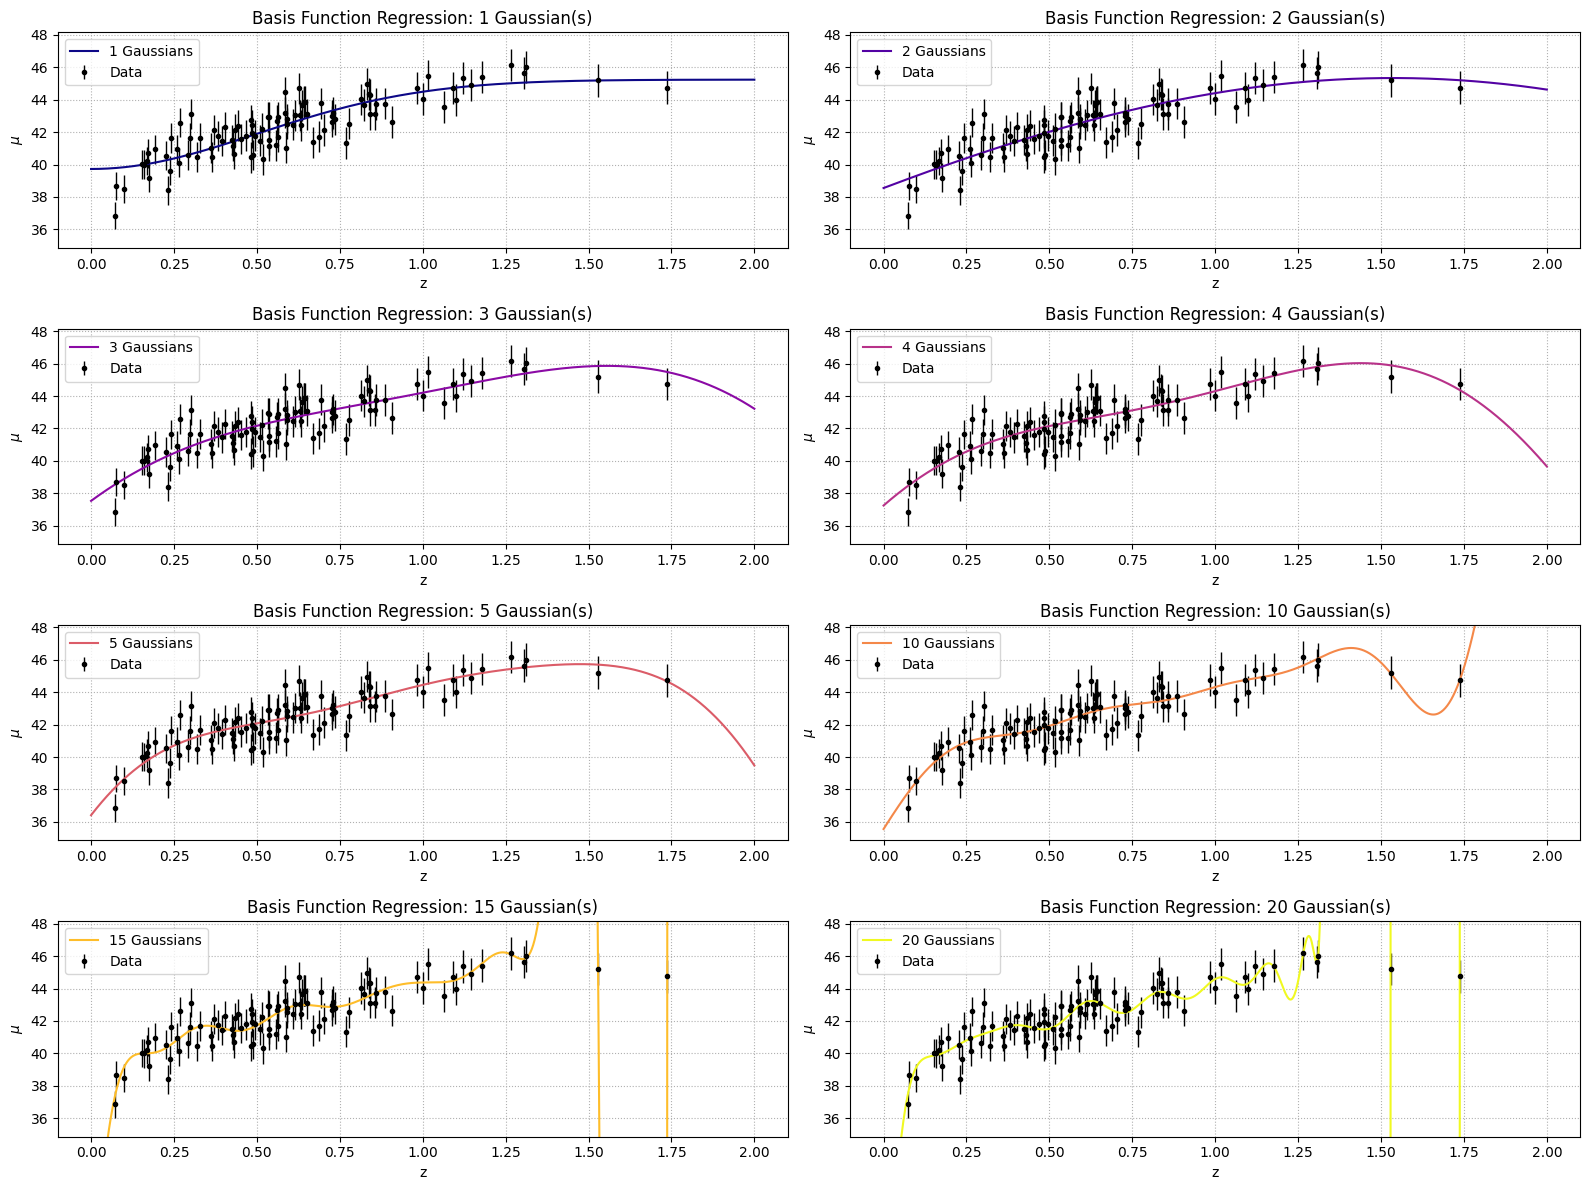

In [ ]:
N_gaussians = [1, 2, 3, 4, 5, 10, 15, 20]
colors = get_cmap('plasma')(np.linspace(0, 1, len(N_gaussians)))

plt.figure(figsize=(16, 12))

for i, (gaussian, color) in enumerate(zip(N_gaussians, colors), 1):
    mu = np.linspace(0, 2, gaussian)[:, None]  # Gaussian centers
    if gaussian > 1:
        sigma = mu[1] - mu[0]  # Consistent sigma
    else:
        sigma = 0.5  # Arbitrary if only one Gaussian

    basis_gauss_reg = BasisFunctionRegression('gaussian', mu=mu, sigma=sigma)
    basis_gauss_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    y_pred_bg = basis_gauss_reg.predict(x_grid[:, np.newaxis])
    
    plt.subplot(4, 2, i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', lw=1, label='Data')
    plt.plot(x_grid, y_pred_bg, color=color, label=f'{gaussian} Gaussians')
    plt.ylim(np.min(mu_sample) - 2, np.max(mu_sample) + 2)
    plt.title(f"Basis Function Regression: {gaussian} Gaussian(s)")
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend()
    plt.grid(linestyle=':')

plt.tight_layout()
plt.show()

- From 1 to 5 gaussians the model seems to capture quite well the data distribution
- Higher numbers of gaussians like 10, 15 and 20, shows signs of overfitting.

#### Kernel Regression (Nadaraya-Watson)

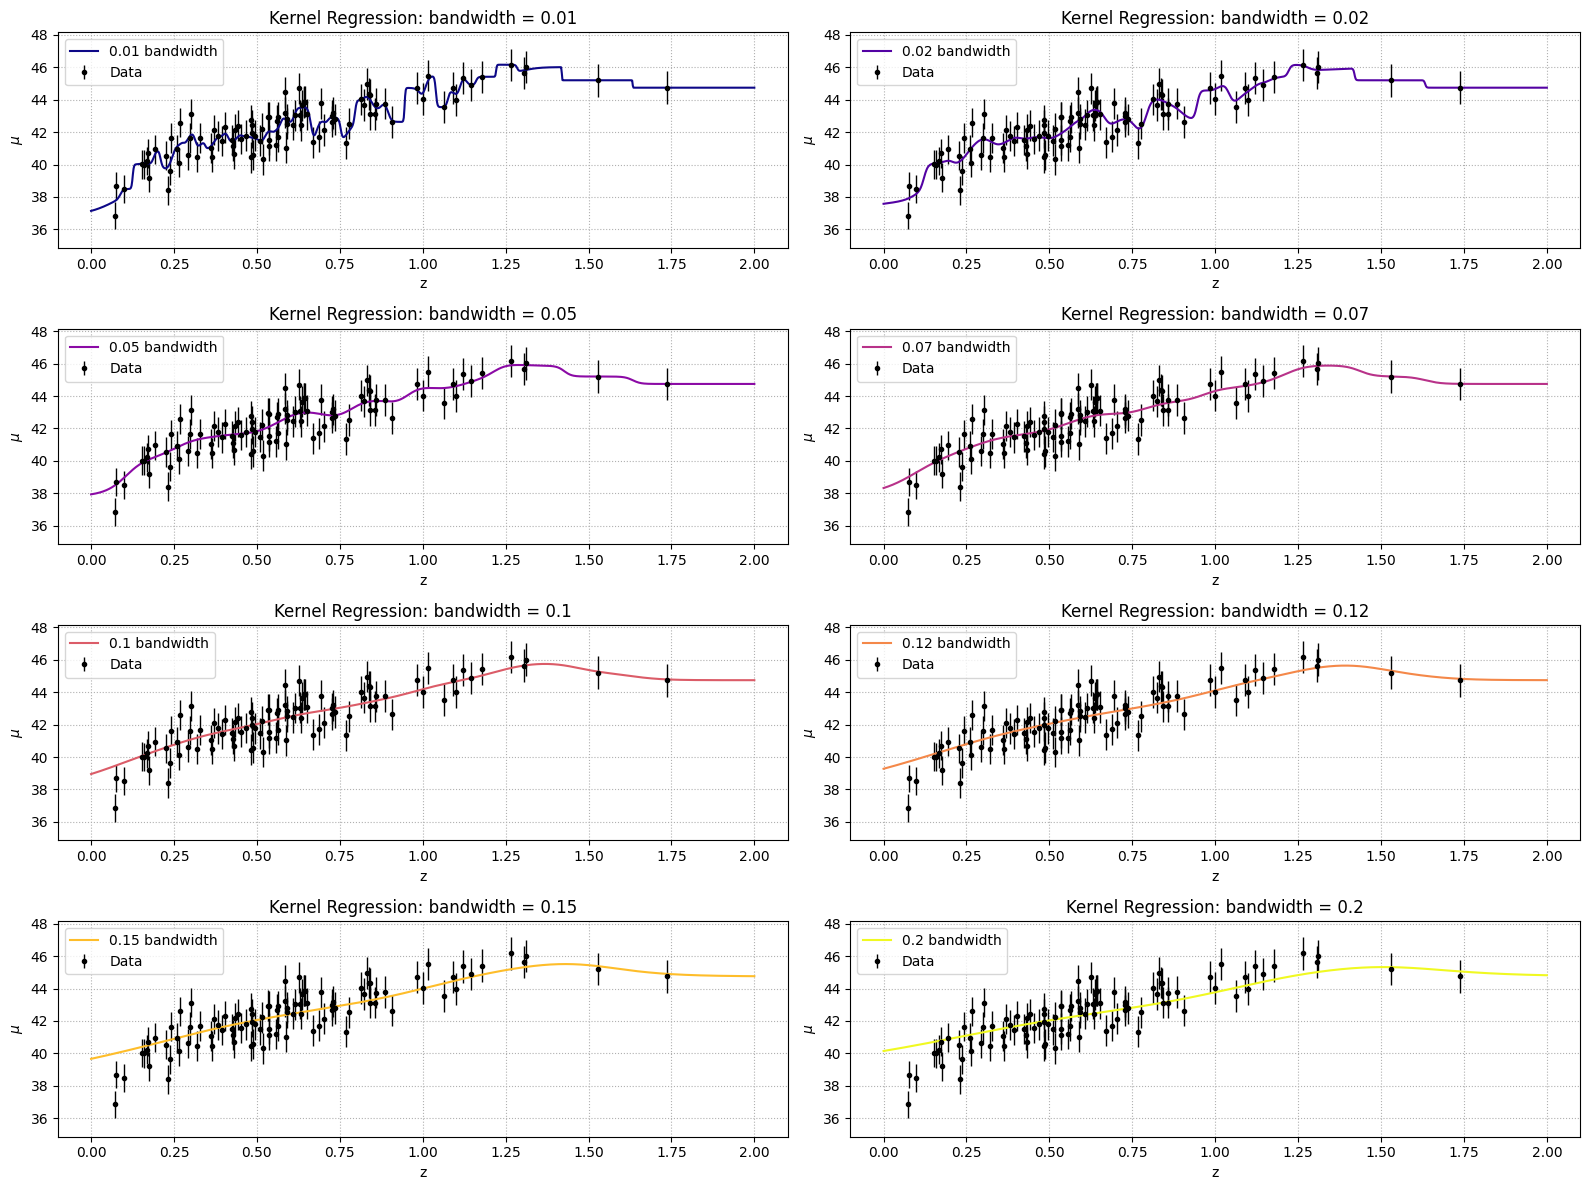

In [ ]:
bandwidths = [0.01, 0.02, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2]
colors = get_cmap('plasma')(np.linspace(0, 1, len(bandwidths)))

plt.figure(figsize=(16, 12))

for i, (bw, color) in enumerate(zip(bandwidths, colors), 1):
    kernel_reg = NadarayaWatson('gaussian', h=bw)
    kernel_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    y_pred_kernel = kernel_reg.predict(x_grid[:, np.newaxis])
    
    plt.subplot(4, 2, i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', lw=1, label='Data')
    plt.plot(x_grid, y_pred_kernel, color=color, label=f'{bw} bandwidth')
    plt.ylim(np.min(mu_sample) - 2, np.max(mu_sample) + 2)
    plt.title(f"Kernel Regression: bandwidth = {bw}")
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend()
    plt.grid(linestyle=':')

plt.tight_layout()
plt.show()

In Kernel Regression, overfitting occurs when the bandwidth is too small, like 0.01 or 0.02, leaving very little flexibility for new data to be properly captured by the model. In practice, this means that with too small a bandwidth the model cannot be reliably used for future applications.

In this case, I think that the it's better choose a bandwidth between 0.1 and 0.2. This because for lower values of bandwitìdth the estimated data distribution lose some important behaviour of data, especially at low $z$.

### Cross Validation

`GridSearchCV` only works directly with scikit-learn-compatible estimators (i.e., classes that implement `.fit()`, `.predict()`, and inherit from `BaseEstimator`). So I need to create wrappers around my models like `PolynomialRegression`, `BasisFunctionRegression`, and `NadarayaWatson`.

But since I don't really visualize `GridSearchCV`, I want to check the crossvalidation with another method: I decided to use the implementation of *K-Fold* and manually changed the number of *K-Fold* $k$ until I found a convergent result. I think that the outliers strongly affect the error of our model especially when taken into the testing set, so I took a better proportion of training sets (90/100).

In [ ]:
class PolyRegWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, degree=1):
        self.degree = degree

    def fit(self, X, y):
        self.model = PolynomialRegression(self.degree)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)
    

class BasisFunctionWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_gaussians=1):
        self.n_gaussians = n_gaussians

    def fit(self, X, y):
        mu = np.linspace(0, 2, self.n_gaussians)[:, None]
        if self.n_gaussians > 1:
            sigma = mu[1] - mu[0] 
        else:
            sigma = 0.5
        self.model = BasisFunctionRegression('gaussian', mu=mu, sigma=sigma)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)
    

class NWWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, h=0.1):
        self.h = h

    def fit(self, X, y):
        self.model = NadarayaWatson('gaussian', h=self.h)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
#cross validation functions
def error(X, y, regressor):
    return np.sqrt( np.sum(( y - regressor.predict(X) )**2) / len(X) )

    
def cv_vs_t_err(X, y, dy, regressor_type, k):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=10)  # fixed the shuffling
    
    t_err = []
    cv_err = []
    
    for t_index, cv_index in kf.split(X):
        
        regressor_type.fit(X[t_index], y[t_index], dy[t_index])
        
        t_err.append(error(X[t_index], y[t_index], regressor_type))
        cv_err.append(error(X[cv_index], y[cv_index], regressor_type))
    
    return np.median(t_err), np.median(cv_err)  # chose median because mean strongly depends on outliers

Since the linear regression does not require any additional parameter, I am starting to cross validate from the Polynomial Regression.

#### Polynomial Regression CV

In [ ]:
# Polynomial Regression
param_grid_pol = {'degree': degrees}
grid_poly = GridSearchCV(PolyRegWrapper(), param_grid_pol, cv=5, scoring='neg_mean_squared_error')
grid_poly.fit(z_sample[:, np.newaxis], mu_sample)
print(f"Best polynomial degree: {grid_poly.best_params_['degree']}")

Best polynomial degree: 2


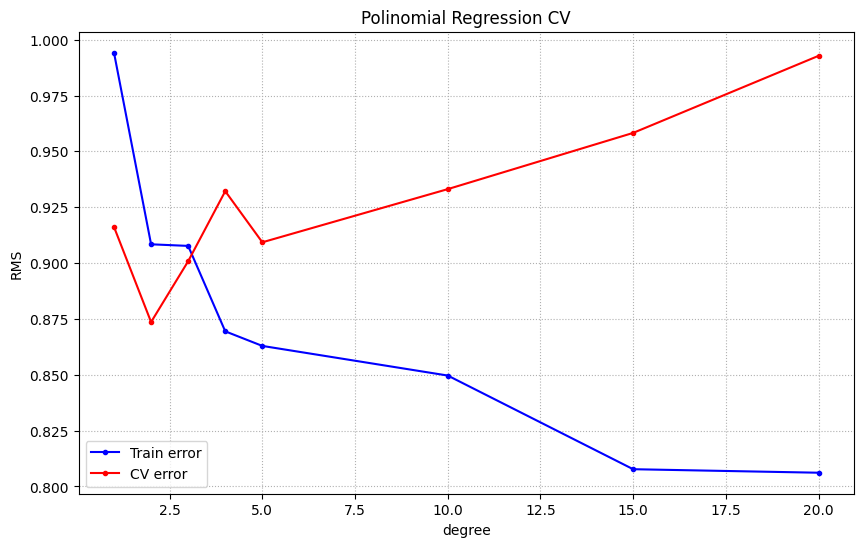

Best polynomial degree: 2 , with error value: 0.874


In [ ]:
# Cross Validation
cv_err_pr = []
t_err_pr = []

for d in degrees: 
    regressor_type = PolynomialRegression(d) 
    t_err_i, cv_err_i = cv_vs_t_err(z_sample[:, np.newaxis], mu_sample, dmu, regressor_type, 11)
    cv_err_pr.append(cv_err_i)
    t_err_pr.append(t_err_i)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(degrees, t_err_pr, c='blue', label='Train error', marker='.')
plt.plot(degrees, cv_err_pr, c='red', label='CV error', marker='.')
plt.xlabel("degree")
plt.ylabel("RMS")
plt.title(f"Polinomial Regression CV")
plt.legend()
plt.grid(linestyle=':')
plt.show()

print(f"Best polynomial degree: {degrees[np.argmin(cv_err_pr)]} , with error value: {np.min(cv_err_pr):.3f}")

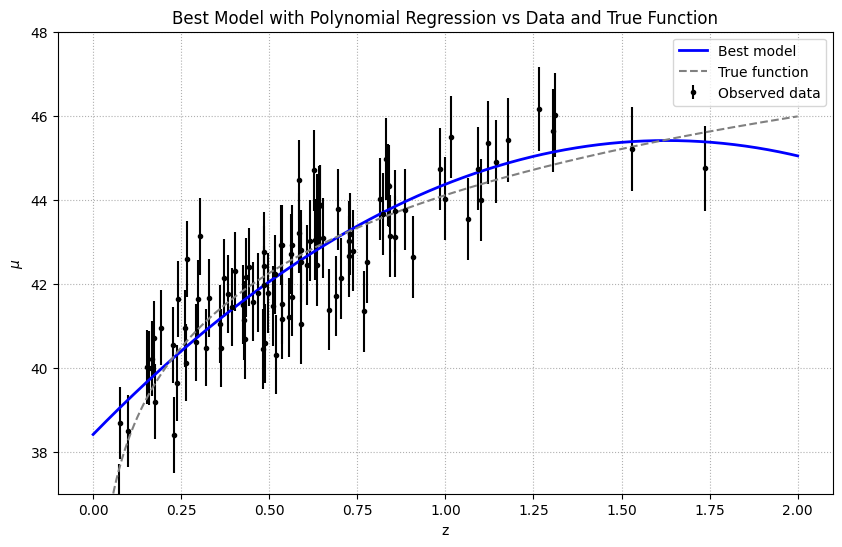

In [ ]:
# Best model
best_model_pol = PolynomialRegression(grid_poly.best_params_['degree'])
best_model_pol.fit(z_sample[:, np.newaxis], mu_sample, dmu)
y_plot_pol = best_model_pol.predict(x_grid[:, np.newaxis])

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', label='Observed data')
plt.plot(x_grid, y_plot_pol, lw=2, color='blue', label='Best model')
plt.plot(z, mu_true, '--', c='gray', label='True function')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Best Model with Polynomial Regression vs Data and True Function")
plt.ylim(37, 48)
plt.legend()
plt.grid(linestyle=':')
plt.show()

#### Basis Function Regression CV 

In [ ]:
# Basis Function Regression
param_grid_bg = {'n_gaussians': N_gaussians}
grid_basis_gauss = GridSearchCV(BasisFunctionWrapper(), param_grid_bg, cv=5, scoring='neg_mean_squared_error')
grid_basis_gauss.fit(z_sample[:, np.newaxis], mu_sample)
print(f"Best number of Gaussians: {grid_basis_gauss.best_params_['n_gaussians']}")

Best number of Gaussians: 2


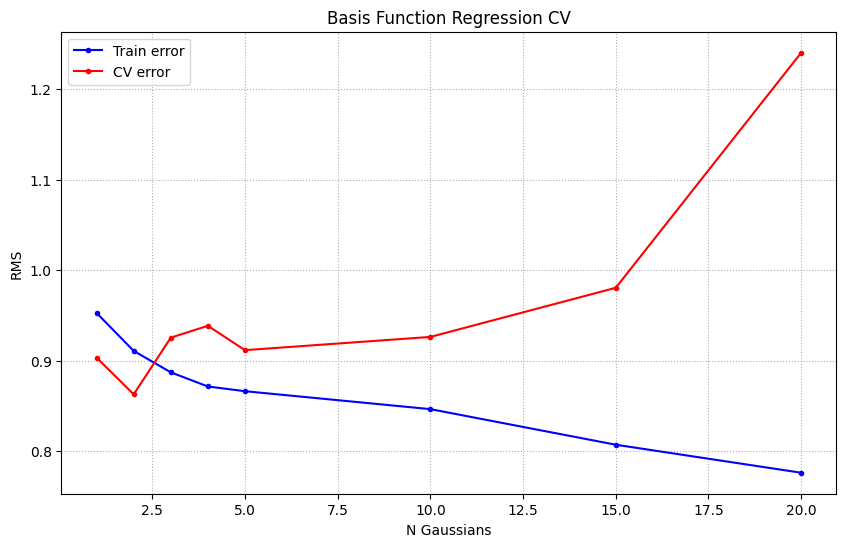

Best number of Gaussians: 2 , with error value: 0.863


In [ ]:
# Cross Validation
cv_err_bgr = []
t_err_bgr = []

for n in N_gaussians: 
    mu = np.linspace(0, 2, n)[:, None]  # Gaussian centers
    if n > 1:
        sigma = mu[1] - mu[0]  # Consistent sigma
    else:
        sigma = 0.5  # Arbitrary if only one Gaussian
    
    regressor_type = BasisFunctionRegression(basis_func='gaussian', mu=mu, sigma=sigma)
    t_err_i, cv_err_i = cv_vs_t_err(z_sample[:, np.newaxis], mu_sample, dmu, regressor_type, 11)
    cv_err_bgr.append(cv_err_i)
    t_err_bgr.append(t_err_i)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(N_gaussians, t_err_bgr, c='blue', label='Train error', marker='.')
plt.plot(N_gaussians, cv_err_bgr, c='red', label='CV error', marker='.')
plt.xlabel("N Gaussians")
plt.ylabel("RMS")
plt.title(f"Basis Function Regression CV")
plt.legend()
plt.grid(linestyle=':')
plt.show()

print(f"Best number of Gaussians: {N_gaussians[np.argmin(cv_err_bgr)]} , with error value: {np.min(cv_err_bgr):.3f}")

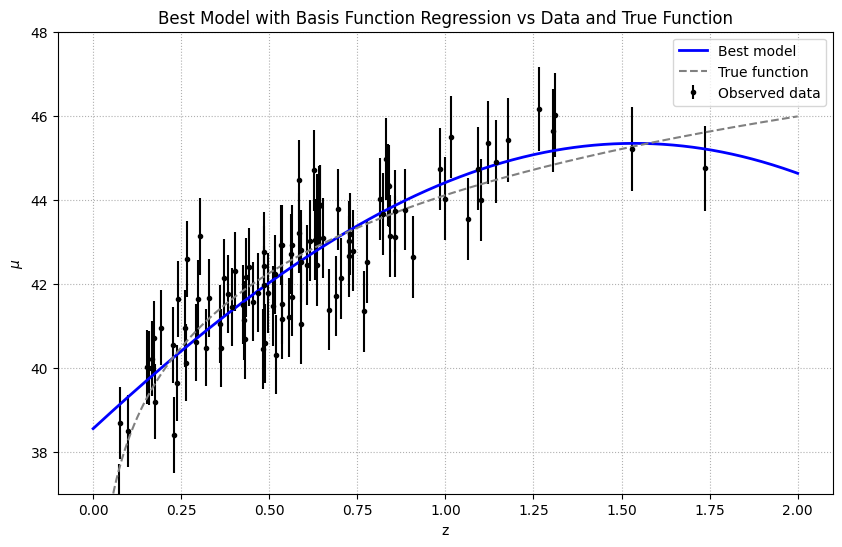

In [ ]:
# Best model
mu = np.linspace(0, 2, grid_basis_gauss.best_params_['n_gaussians'])[:, None]
sigma = mu[1]-mu[0]

best_model_bg =  BasisFunctionRegression('gaussian', mu = mu , sigma = sigma)
best_model_bg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
y_plot_bg = best_model_bg.predict(x_grid[:, np.newaxis])

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', label='Observed data')
plt.plot(x_grid, y_plot_bg, lw=2, color='blue', label='Best model')
plt.plot(z, mu_true, '--', c='gray', label='True function')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Best Model with Basis Function Regression vs Data and True Function")
plt.ylim(37, 48)
plt.legend()
plt.grid(linestyle=':')
plt.show()

#### Kernel Regression CV

In [ ]:
# Kernel Regression
param_grid_kernel = {'h': bandwidths}
grid_kernel = GridSearchCV(NWWrapper(), param_grid_kernel, cv=5, scoring='neg_mean_squared_error')
grid_kernel.fit(z_sample[:, np.newaxis], mu_sample)
print(f"Best kernel bandwidth: {grid_kernel.best_params_['h']}")

Best kernel bandwidth: 0.05


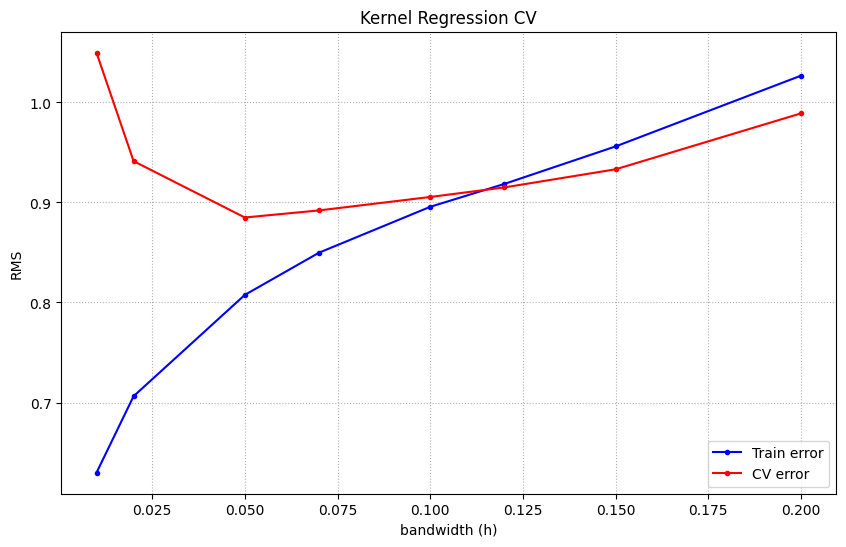

Best kernel bandwidth:: 0.05 , with error value: 0.885


In [ ]:
# Cross Validation
cv_err_kr = []
t_err_kr = []

for bw in bandwidths: 
    regressor_type = NadarayaWatson(kernel='gaussian', h=bw)
    t_err_i, cv_err_i = cv_vs_t_err(z_sample[:, np.newaxis], mu_sample, dmu, regressor_type, 8)
    cv_err_kr.append(cv_err_i)
    t_err_kr.append(t_err_i)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, t_err_kr, c='blue', label='Train error', marker='.')
plt.plot(bandwidths, cv_err_kr, c='red', label='CV error', marker='.')
plt.xlabel("bandwidth (h)")
plt.ylabel("RMS")
plt.title(f"Kernel Regression CV")
plt.legend()
plt.grid(linestyle=':')
plt.show()

print(f"Best kernel bandwidth:: {bandwidths[np.argmin(cv_err_kr)]} , with error value: {np.min(cv_err_kr):.3f}")

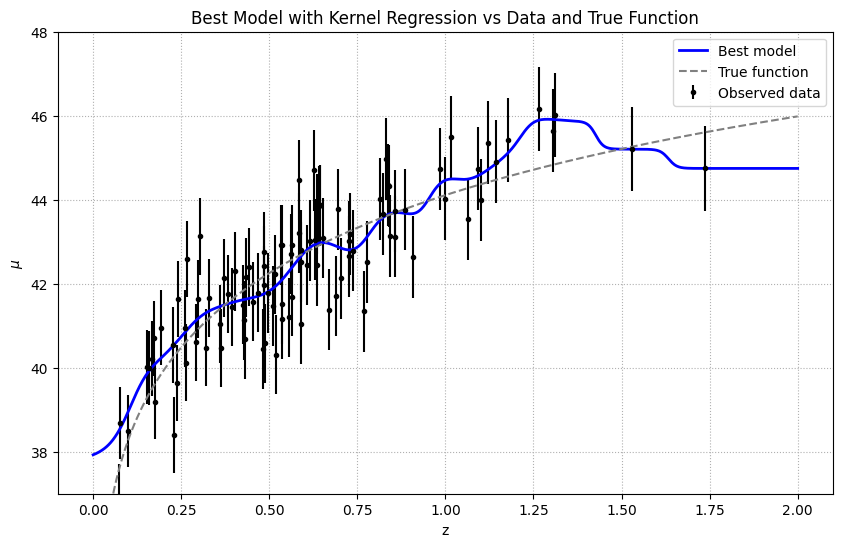

In [ ]:
# Best model
best_model_kernel = NadarayaWatson('gaussian', h=grid_kernel.best_params_['h'])
best_model_kernel.fit(z_sample[:, np.newaxis], mu_sample, dmu)
y_plot_kernel = best_model_kernel.predict(x_grid[:, np.newaxis])

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', label='Observed data')
plt.plot(x_grid, y_plot_kernel, lw=2, color='blue', label='Best model')
plt.plot(z, mu_true, '--', c='gray', label='True function')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Best Model with Kernel Regression vs Data and True Function")
plt.ylim(37, 48)
plt.legend()
plt.grid(linestyle=':')
plt.show()

### Learning Curves

In this section I will explore what happens when I change the number of datapoints and plot the resulting learning curves. I choose to set more points and then I move on to evaluate the CV and training error.

In [ ]:

z_resample, mu_resample, dmu_r = generate_mu_z(1000, random_state=1234)

X_re = z_resample[:, np.newaxis]
y_re = mu_resample

In [ ]:
X_train, X_test, ydy_train, ydy_test = train_test_split(X_re, np.array([y_re, dmu_r]).T, test_size=0.33, random_state=42)
Y_train, dy_train = ydy_train.T
Y_test, dy_test = ydy_test.T

#### Polynomial Regression

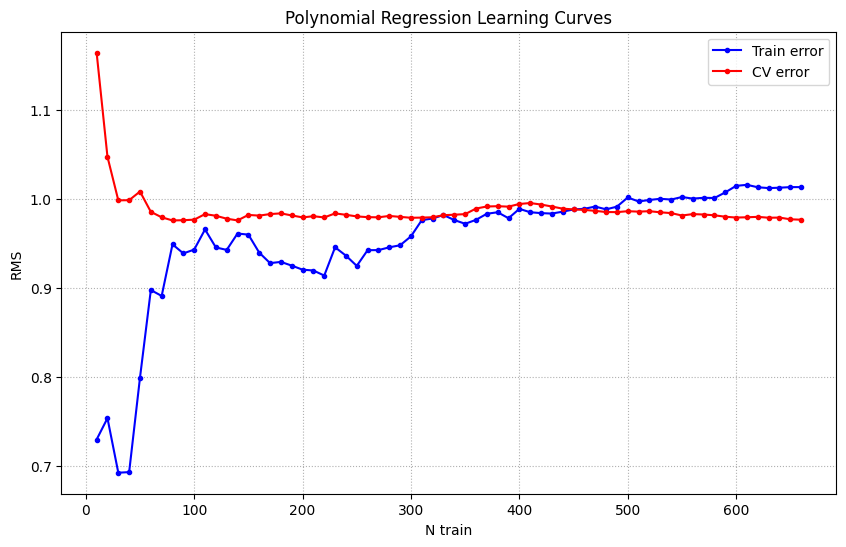

In [ ]:
N_cv_err_pr = []
N_t_err_pr = []
    
for N in range(10, len(X_train), 10):                                                                    
    pr = PolynomialRegression(np.argmin(cv_err_pr) + 1) 
    pr.fit(X_train[:N], Y_train[:N], dy_train[:N])                                                                                                                                                            
    
    N_t_err_pr.append(error(X_train[:N], Y_train[:N], pr))                                                                       
    N_cv_err_pr.append(error(X_test, Y_test, pr))

plt.figure(figsize=(10, 6))
plt.plot(range(10, len(X_train), 10), N_t_err_pr, c='blue', label='Train error', marker='.')
plt.plot(range(10, len(X_train), 10), N_cv_err_pr, c='red', label='CV error', marker='.')
plt.xlabel("N train")
plt.ylabel("RMS")
plt.title("Polynomial Regression Learning Curves")
plt.legend()
plt.grid(linestyle=':')
plt.show()

#### Basis Function Regression

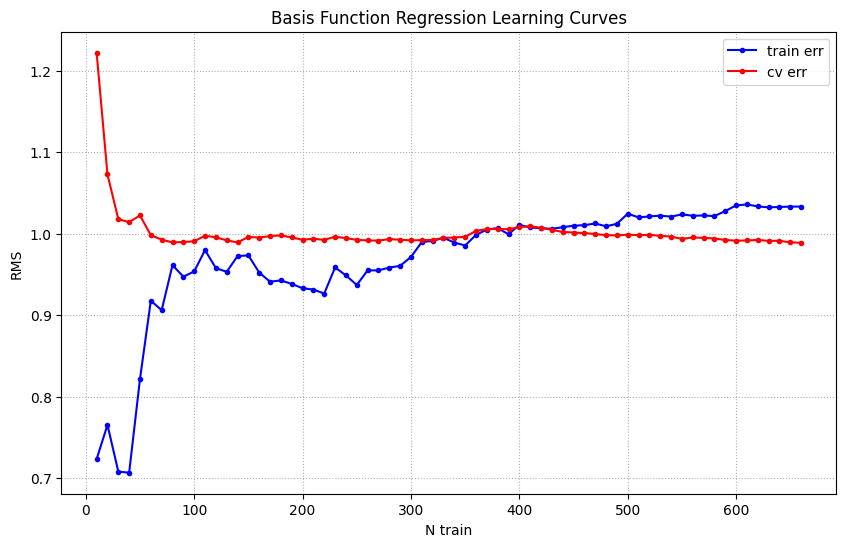

In [ ]:
N_cv_err_bgr = []
N_t_err_bgr = []

for N in range(10, len(X_train), 10):
    X_gridtest = np.linspace(0, 2, N_gaussians[np.argmin(cv_err_bgr)])[:, None]
    sigma_test = X_gridtest[1]-X_gridtest[0]
                                                                                 
    bfr = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test) 
    bfr.fit(X_train[:N], Y_train[:N], dy_train[:N])      
                                                                                                                                                             
    N_t_err_bgr.append(error(X_train[:N], Y_train[:N], bfr))                                                                     
    N_cv_err_bgr.append(error(X_test, Y_test, bfr))


plt.figure(figsize=(10, 6))
plt.plot(range(10, len(X_train), 10), N_t_err_bgr, c='blue', label='train err', marker='.')
plt.plot(range(10, len(X_train), 10), N_cv_err_bgr, c='red', label='cv err', marker='.')
plt.xlabel("N train")
plt.ylabel("RMS")
plt.title("Basis Function Regression Learning Curves")
plt.legend()
plt.grid(linestyle=':')
plt.show()

#### Kernel Regression

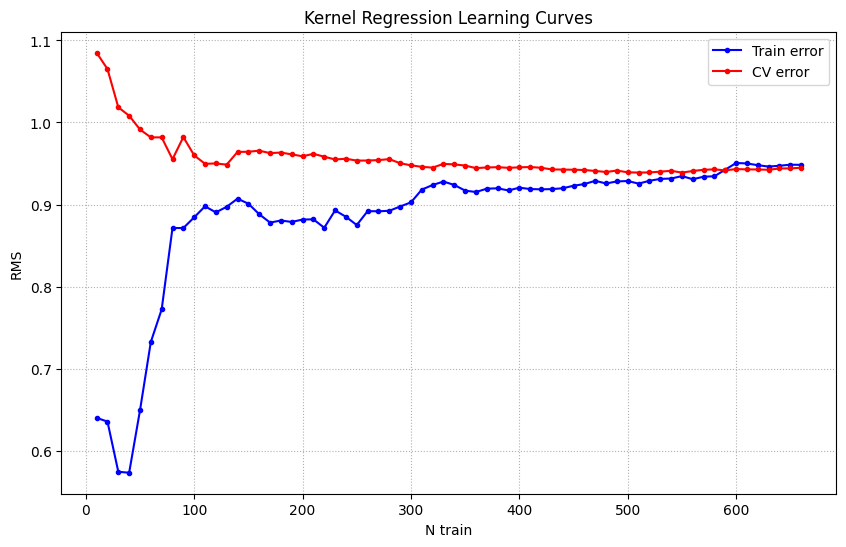

In [ ]:
N_cv_err_kr = []
N_t_err_kr = []
    
for N in range(10, len(X_train), 10):                                                                        
    ndarr = NadarayaWatson(kernel='gaussian', h=bandwidths[np.argmin(cv_err_kr)])
    ndarr.fit(X_train[:N], Y_train[:N], dy_train[:N])                                                                                                                                                              
    
    N_t_err_kr.append(error(X_train[:N], Y_train[:N], ndarr))                                                                            
    N_cv_err_kr.append(error(X_test, Y_test, ndarr))

plt.figure(figsize=(10, 6))
plt.plot(range(10, len(X_train), 10), N_t_err_kr, c='blue', label='Train error', marker='.')
plt.plot(range(10, len(X_train), 10), N_cv_err_kr, c='red', label='CV error', marker='.')
plt.xlabel("N train")
plt.ylabel("RMS")
plt.title("Kernel Regression Learning Curves")
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Part 2

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the `kernels` submodule of sklearn.gaussian_process
- Plot the expectation value of the fit as well as the resulting $1-\sigma$ and $2-\sigma$ contours.
- Interpret the results.

Note. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel

from scipy.stats import gaussian_kde

### Gaussian Process Regressor

In [ ]:
kernel = ConstantKernel(0.5, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
GPR = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
GPR.fit(z_sample[:, np.newaxis], mu_sample)

y_pred_GPR, y_err_GPR = GPR.predict(x_grid[:, np.newaxis], return_std=True)

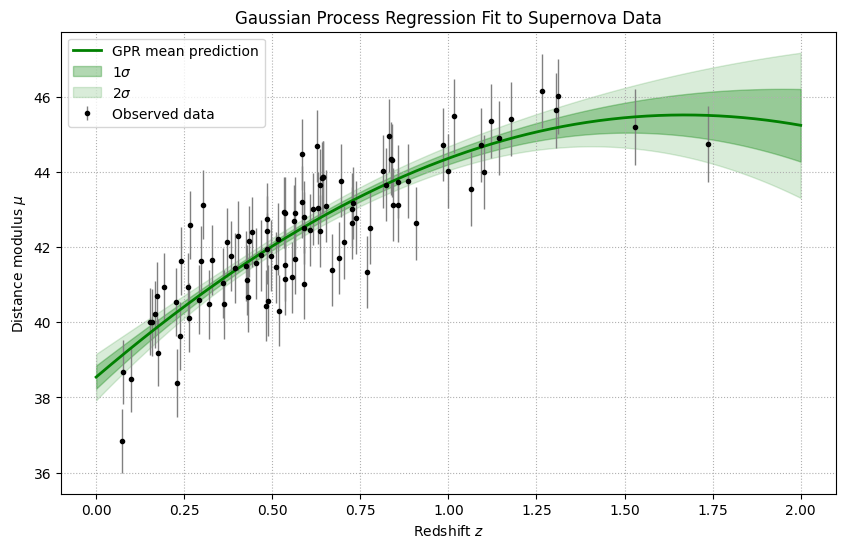

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Observed data')
plt.plot(x_grid, y_pred_GPR, 'g-', lw=2, label='GPR mean prediction')
plt.fill_between(x_grid, y_pred_GPR - y_err_GPR, y_pred_GPR + y_err_GPR, color='green', alpha=0.3, label=r'1$\sigma$')
plt.fill_between(x_grid, y_pred_GPR - 2 * y_err_GPR, y_pred_GPR + 2 * y_err_GPR, color='green', alpha=0.15, label=r'2$\sigma$')
plt.xlabel("Redshift $z$")
plt.ylabel("Distance modulus $\mu$")
plt.title("Gaussian Process Regression Fit to Supernova Data")
plt.legend()
plt.grid(linestyle=':')
plt.show()

### Generate new data

In [ ]:
# Estimate PDF of original z samples
z_pdf = gaussian_kde(z_sample)
z_clone = z_pdf.resample(10 * len(z_sample)).reshape(-1)

# Optionally, clip or constrain to [0, 2]
z_clone = np.clip(z_clone, 0, 2)

In [ ]:
# Predict the new data from GPR model
mu_clone_mean, mu_clone_std = GPR.predict(z_clone[:, None], return_std=True)
mu_clone = np.random.normal(mu_clone_mean, mu_clone_std)

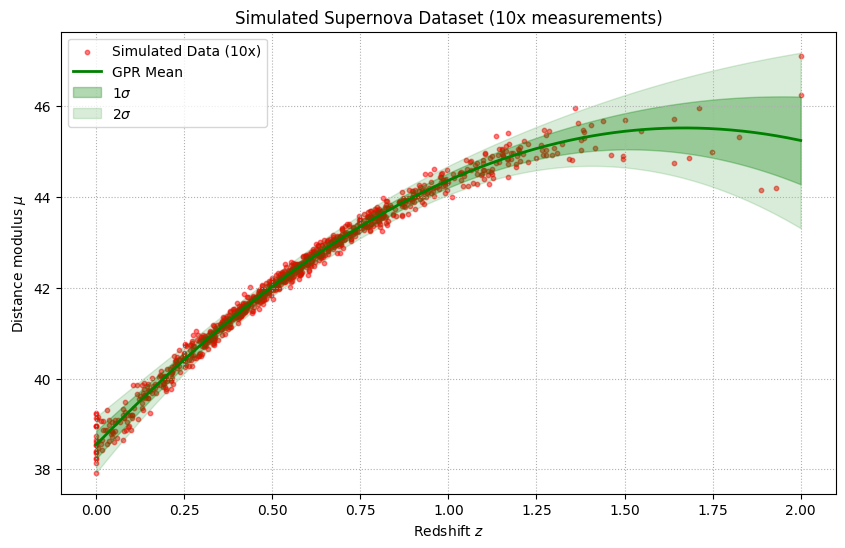

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(z_clone, mu_clone, s=10, alpha=0.5, color='r', label='Simulated Data (10x)')
plt.plot(x_grid, y_pred_GPR, 'g-', lw=2, label='GPR Mean')
plt.fill_between(x_grid, y_pred_GPR - y_err_GPR, y_pred_GPR + y_err_GPR, color='green', alpha=0.3, label=r'1$\sigma$')
plt.fill_between(x_grid, y_pred_GPR - 2 * y_err_GPR, y_pred_GPR + 2 * y_err_GPR, color='green', alpha=0.15, label=r'2$\sigma$')
plt.xlabel("Redshift $z$")
plt.ylabel("Distance modulus $\mu$")
plt.title("Simulated Supernova Dataset (10x measurements)")
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Part 3

We now have a suite of data-driven predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$ CDM. We can do a parametric fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. Hint I always forget these things, my to-go reference is Hogg (2010). The answer is:
 
$$\mu = 5 \log \left( \frac{c/H_0}{10 pc} (1 + z) \int_{0}^{z} \frac{dz'}{\sqrt{\Omega_m(1+z^3) + \Omega_{\Lambda}}}\right)$$
 

- Assuming a flat Universe, we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$.
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
    -   Set up a Bayesian framework and use MCMC.
    - Set up a fully-connected neural network (see end of the class).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

In [ ]:
import pandas as pd
import emcee
import corner

from astropy.cosmology import FlatLambdaCDM

from IPython.display import display
from IPython.display import Math

from dynesty import NestedSampler
from dynesty import plotting as dyplot

from dynesty.utils import resample_equal

In [ ]:
def model_mu(z, theta):
    Omega_m, H0 = theta
    if Omega_m >0: 
        c = FlatLambdaCDM(H0, Omega_m)
        return c.distmod(z).value
    else:
        return 0

### MCMC Sampling

In [ ]:
def log_likelihood(theta, z, mu_obs, mu_err):
    Omega_m, H0 = theta
    mu_model = model_mu(z, theta)
    return -0.5 * np.sum( np.log(2*np.pi*mu_err**2) + ((mu_obs - mu_model) / mu_err)**2)

def log_prior(theta):
    Omega_m, H0 = theta
    if 0.0 < Omega_m < 1.0 and 40 < H0 < 100:
        return 0.0
    else:
        return -np.inf

def log_posterior(theta, z, mu_obs, mu_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, z, mu_obs, mu_err)

In [ ]:
ndim = 2
n_steps = 10000
nwalkers = 8

initial_guess = [0.3, 70]
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_sample, mu_sample, dmu))
sampler.run_mcmc(pos, n_steps, progress=True)

100%|██████████| 10000/10000 [01:26<00:00, 115.79it/s]


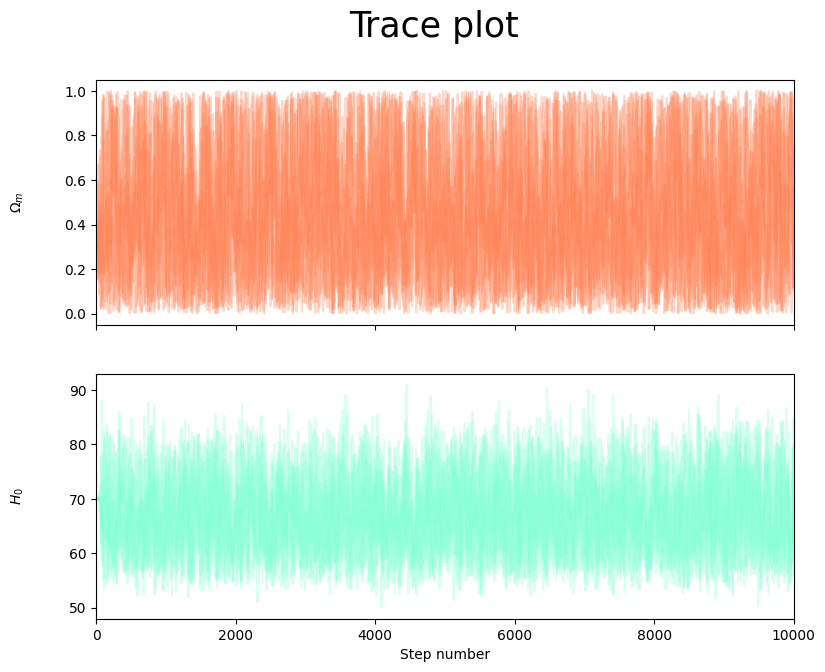

In [ ]:
# Trace Plot
fig, axes = plt.subplots(2, figsize=(9, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"$\Omega_{m}$", r"$H_0$"]
colors = ["coral", "aquamarine"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c=colors[i], alpha=0.3)
    ax.set_xlim(0, samples.shape[0])  # Automatically use chain length
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")

fig.suptitle("Trace plot", fontsize=25)
plt.show()

In [ ]:
tau = sampler.get_autocorr_time()
burn = 100

flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True) 

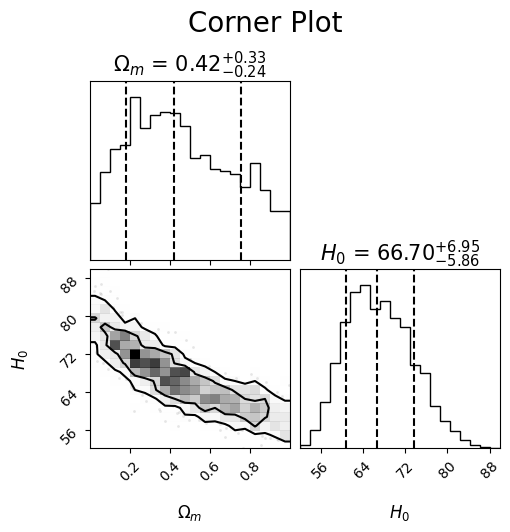

In [ ]:
# Corner Plot
labels = [r"$\Omega_{m}$", r"$H_0$"]

fig = corner.corner(
    flat_samples, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  
    levels=([0.68, 0.95]),
    show_titles=True,
    title_kwargs={"fontsize": 15},
    label_kwargs=dict(fontsize=12)
)
fig.suptitle("Corner Plot", fontsize = 20)
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
# Parameters estimation
labels = [r"\Omega_{m}", r"H_0"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"${0} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}$".format(labels[i], mcmc[1], q[0], q[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Correlation coefficient
corr_matrix = np.corrcoef(flat_samples.T)
corr = corr_matrix[0, 1]

print(f"Correlation coefficient between Ωₘ and H₀: {corr:.3f}")

Correlation coefficient between Ωₘ and H₀: -0.862


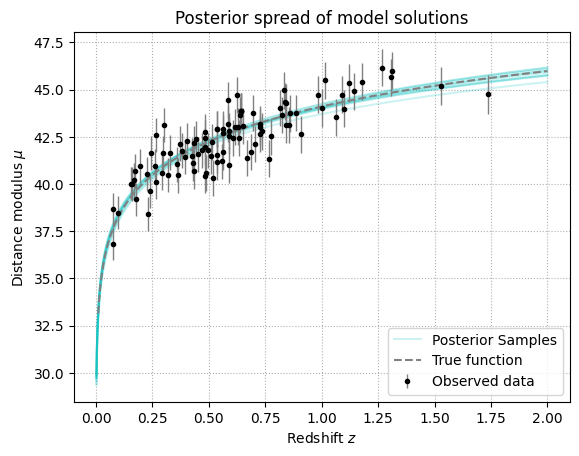

In [ ]:
# Posterior spread of model solutions
idx = np.random.choice(len(flat_samples), size=10, replace=False)
random_samples = flat_samples[idx]

for i, theta in enumerate(random_samples):
    y_model = model_mu(x_grid, theta)
    label = "Posterior Samples" if i == 0 else None
    plt.plot(x_grid, y_model, color='c', alpha=0.2, label=label)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Observed data')
plt.plot(z, mu_true, '--', c='gray', label='True function')
plt.title("Posterior spread of model solutions")
plt.xlabel("Redshift $z$")
plt.ylabel("Distance modulus $\mu$")
plt.legend()
plt.grid(linestyle=":")
plt.show()

### Model Comparison: Nested Sampling

#### Model with No Dark Energy

In [ ]:
def model_noDE(z, H0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=1.0)
    mu_model = cosmo.distmod(z).value

    return mu_model


def loglike_noDE(theta):
    (H0,) = theta
    
    cosmo = FlatLambdaCDM(H0=H0, Om0=1.0)
    mu_model = cosmo.distmod(z_sample).value
    
    chi2 = np.sum(((mu_sample - mu_model) / dmu)**2)
    return -0.5 * chi2

def prior_transform_noDE(u):
    uH0 = u[0]
    H0 = 40 + 60 * uH0   # Uniform prior [40, 100]
    return (H0,)

In [ ]:
sampler_noDE = NestedSampler(loglike_noDE, prior_transform_noDE, ndim=1)
sampler_noDE.run_nested()
res_noDE = sampler_noDE.results

1576it [00:12, 130.71it/s, +500 | bound: 0 | nc: 1 | ncall: 11659 | eff(%): 18.604 | loglstar:   -inf < -47.102 <    inf | logz: -49.353 +/-  0.039 | dlogz:  0.001 >  0.509]


In [ ]:
logZ_noDE = res_noDE.logz[-1]
logZerr_noDE = res_noDE.logzerr[-1]

print(f'Marginalised evidence (using static sampler) is {logZ_noDE:.3f} ± {logZerr_noDE:.3f}')

Marginalised evidence (using static sampler) is -49.353 ± 0.113


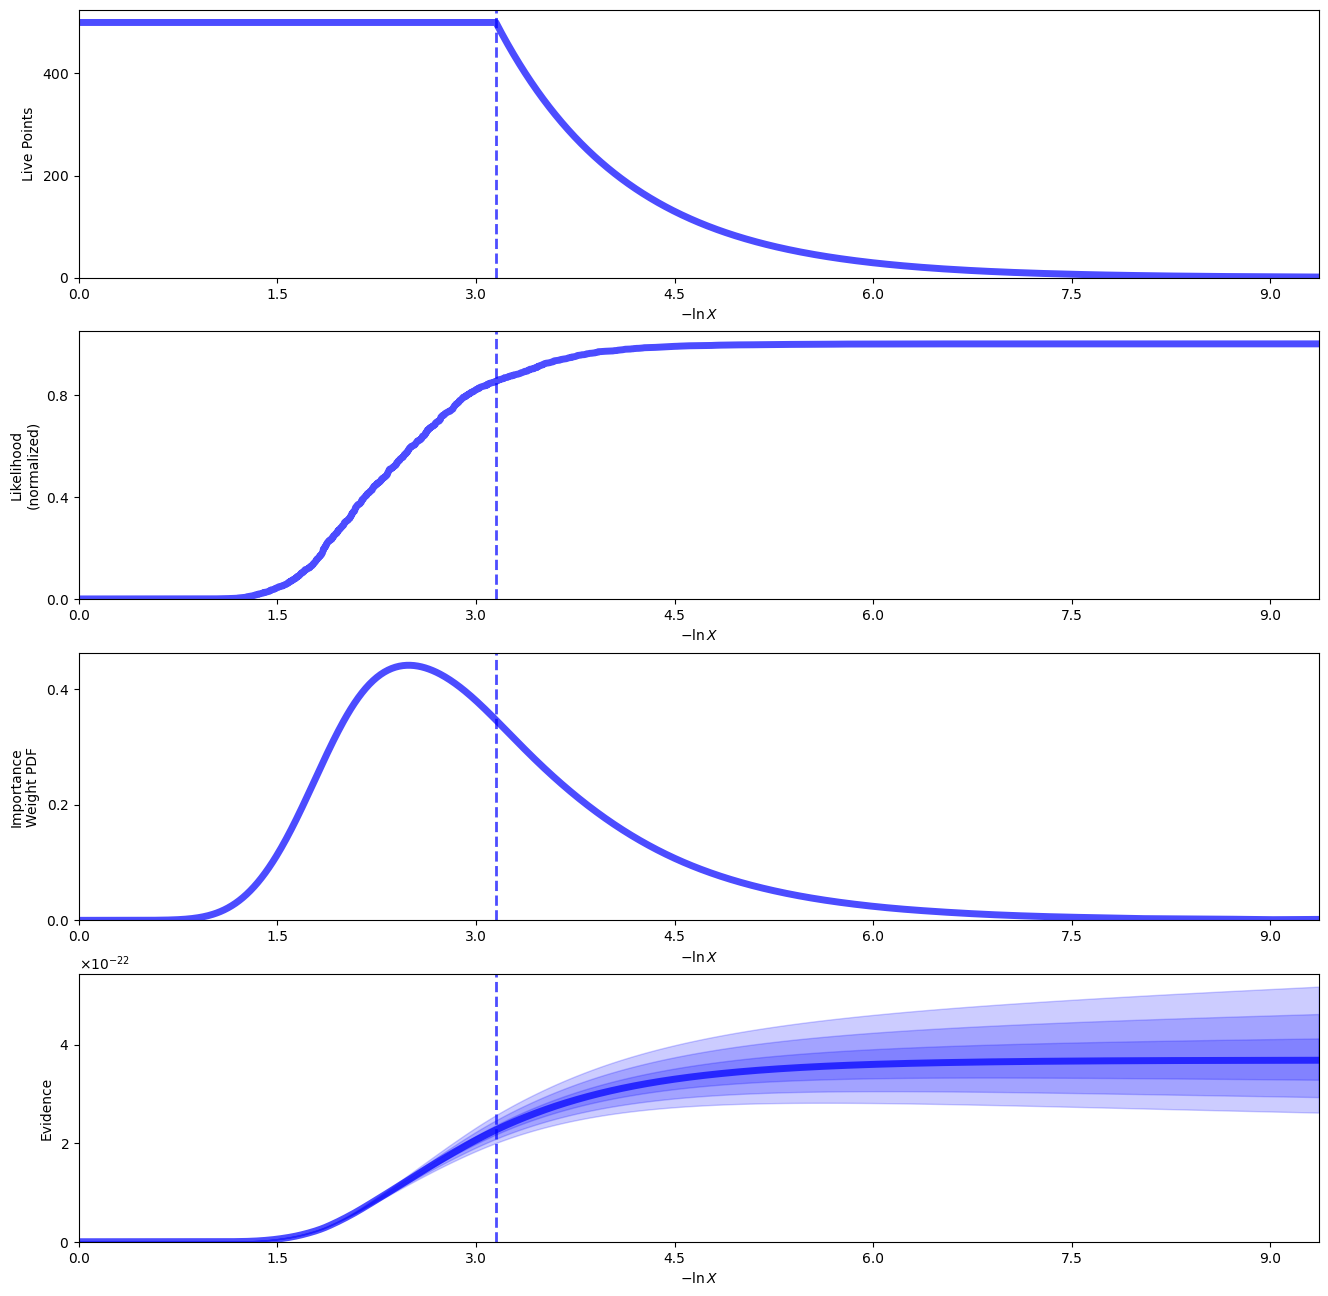

In [ ]:
rfig, raxes = dyplot.runplot(res_noDE)

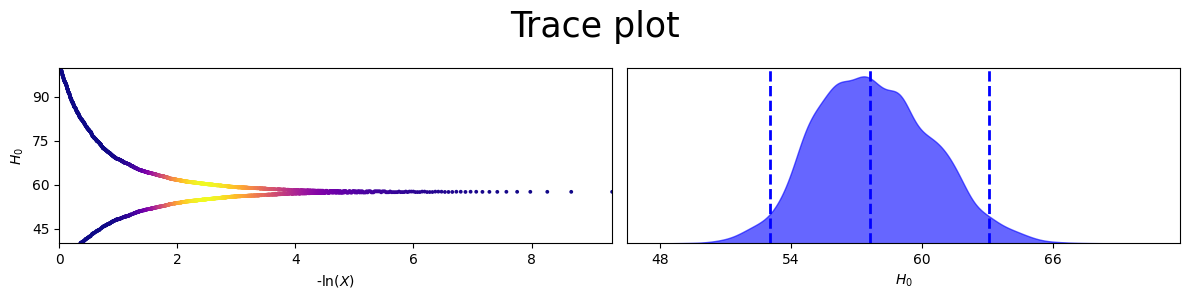

In [ ]:
# Trace Plot
tfig, taxes = dyplot.traceplot(res_noDE, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$H_0$")
taxes[0][1].set_xlabel("$H_0$")

tfig.suptitle('Trace plot', fontsize=25)
tfig.tight_layout()

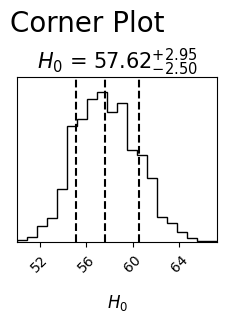

In [387]:
# Corner Plot
weights = np.exp(res_noDE['logwt'] - res_noDE['logz'][-1])
postsamples_noDE = resample_equal(res_noDE.samples, weights)

labels = [r"$H_0$"]

fig = corner.corner(
    postsamples_noDE,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    levels=([0.68, 0.95]),
    show_titles=True,
    title_kwargs={"fontsize": 15},
    label_kwargs=dict(fontsize=12)
)

fig.suptitle("Corner Plot", fontsize=20)
plt.subplots_adjust(top=0.78)
plt.show()

/home/alessia_pozzi/.local/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


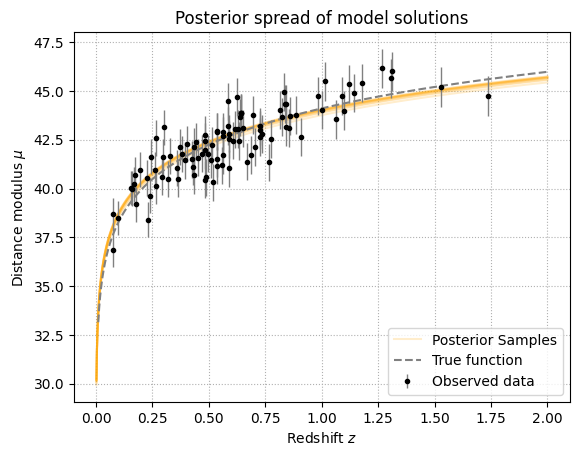

In [ ]:
# Posterior spread of model solutions
idx = np.random.choice(len(postsamples_noDE), size=10, replace=False)
random_samples = postsamples_noDE[idx]

for i, sample in enumerate(random_samples):
    H0 = sample[0]
    y_model = model_noDE(x_grid, H0)
    if i == 0: 
        label = "Posterior Samples"
    else: 
        label = None
    plt.plot(x_grid, y_model, color='orange', alpha=0.2, label=label)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Observed data')
plt.plot(z, mu_true, '--', c='gray', label='True function')
plt.title("Posterior spread of model solutions")
plt.xlabel("Redshift $z$")
plt.ylabel("Distance modulus $\mu$")
plt.legend()
plt.grid(linestyle=":")
plt.show()

#### Model with Dark Energy

In [389]:
def loglike_lcdm(theta):
    Omega_m, H0 = theta
    if Omega_m <= 0 or Omega_m >= 1:
        return -np.inf
    
    cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m)
    mu_model = cosmo.distmod(z_sample).value
    
    chi2 = np.sum(((mu_sample - mu_model) / dmu)**2)
    return -0.5 * chi2

def prior_transform_lcdm(u):
    u_Omega_m, u_H0 = u
    Omega_m = 0.05 + 0.95 * u_Omega_m     # Uniform prior [0.05, 1.0]
    H0 = 40 + 60 * u_H0                   # Uniform prior [40, 100]
    return Omega_m, H0

In [390]:
sampler_lcdm = NestedSampler(loglike_lcdm, prior_transform_lcdm, ndim=2)
sampler_lcdm.run_nested()
res_lcdm = sampler_lcdm.results

1592it [00:15, 106.11it/s, +500 | bound: 0 | nc: 1 | ncall: 12972 | eff(%): 16.774 | loglstar:   -inf < -46.386 <    inf | logz: -48.714 +/-  0.044 | dlogz:  0.001 >  0.509]


In [391]:
logZ_lcdm = res_lcdm.logz[-1]
logZerr_lcdm = res_lcdm.logzerr[-1]

print(f'Marginalised evidence (using static sampler) is {logZ_lcdm:.3f} ± {logZerr_lcdm:.3f}')

Marginalised evidence (using static sampler) is -48.714 ± 0.115


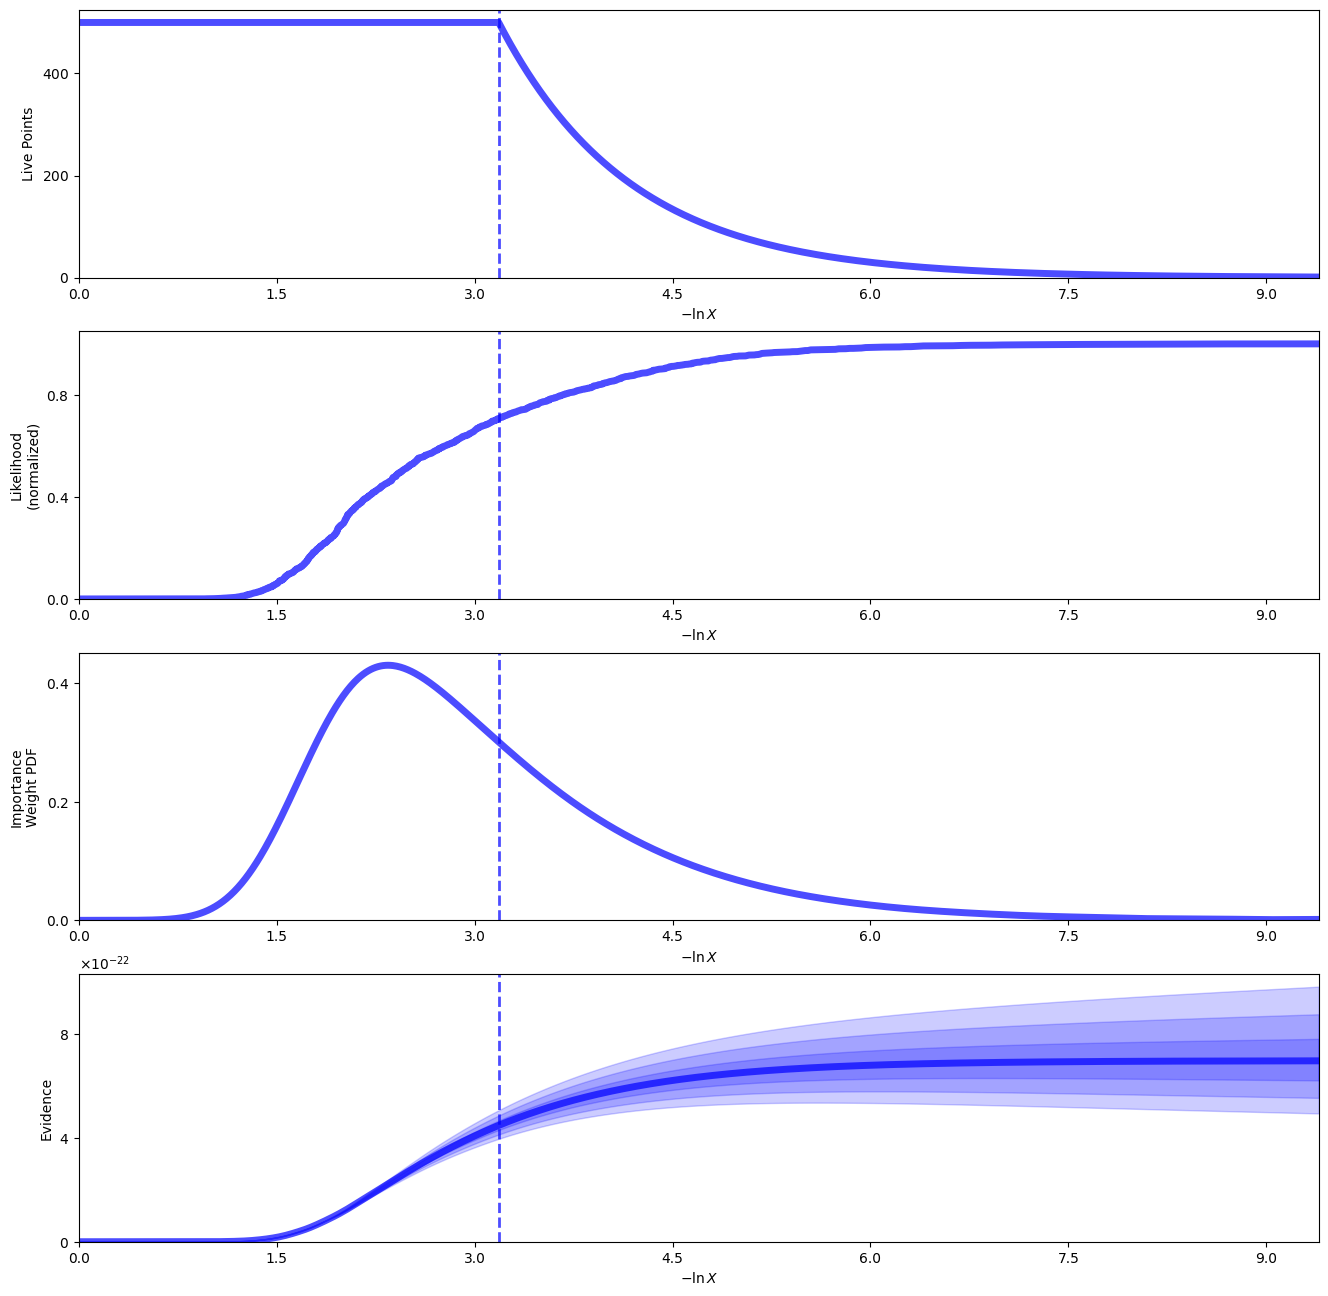

In [392]:
rfig, raxes = dyplot.runplot(res_lcdm)

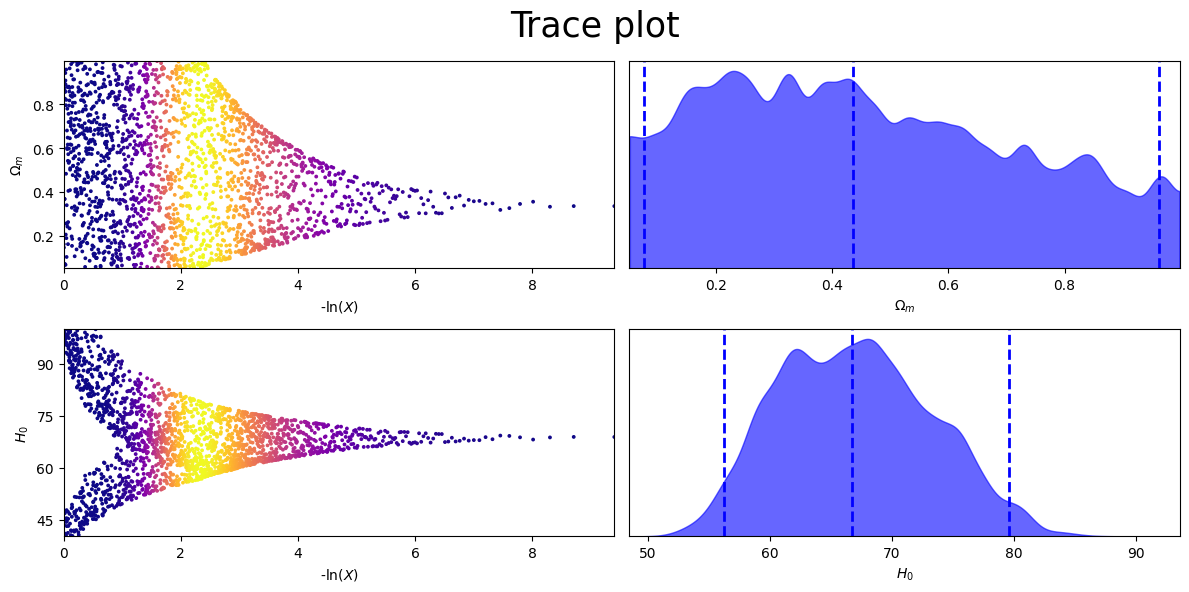

In [393]:
# Trace Plot
tfig, taxes = dyplot.traceplot(res_lcdm, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$\Omega_{m}$")
taxes[0][1].set_xlabel("$\Omega_{m}$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$H_0$")
taxes[1][1].set_xlabel("$H_0$")

tfig.suptitle('Trace plot', fontsize=25)
tfig.tight_layout()

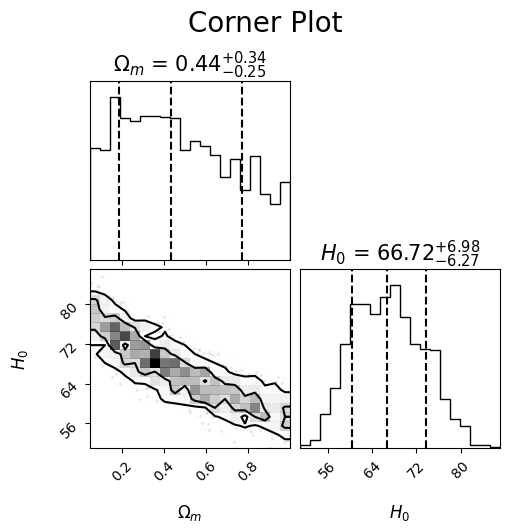

In [394]:
# Corner Plot
weights = np.exp(res_lcdm['logwt'] - res_lcdm['logz'][-1])
postsamples = resample_equal(res_lcdm.samples, weights)

labels = [r"$\Omega_{m}$", r"$H_0$"]

fig = corner.corner(
    postsamples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    levels=([0.68, 0.95]),
    show_titles=True,
    title_kwargs={"fontsize": 15},
    label_kwargs=dict(fontsize=12)
)

fig.suptitle("Corner Plot", fontsize=20)
plt.subplots_adjust(top=0.85)
plt.show()

In [396]:
# Correlation coefficient
corr_matrix = np.corrcoef(postsamples.T)
corr = corr_matrix[0, 1]

print(f"Correlation coefficient between Ωₘ and H₀: {corr:.3f}")

Correlation coefficient between Ωₘ and H₀: -0.874


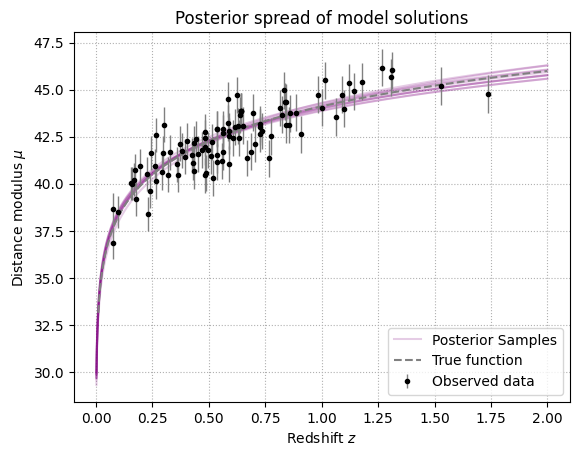

In [401]:
# Posterior spread of model solutions
idx = np.random.choice(len(postsamples), size=10, replace=False)
random_samples = postsamples[idx]

for i, theta in enumerate(random_samples):
    y_model = model_mu(x_grid, theta)
    if i == 0: 
        label = "Posterior Samples"
    else: 
        label = None
    plt.plot(x_grid, y_model, color='purple', alpha=0.2, label=label)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Observed data')
plt.plot(z, mu_true, '--', c='gray', label='True function')
plt.title("Posterior spread of model solutions")
plt.xlabel("Redshift $z$")
plt.ylabel("Distance modulus $\mu$")
plt.legend()
plt.grid(linestyle=":")
plt.show()

#### Model Comparison

In [406]:
B_12 = np.exp(logZ_lcdm) / np.exp(logZ_noDE)
print(f"Bayesian factor: B = {B_12:.3f}")

Bayesian factor: B = 1.895


I obtained a Bayesian factor $B_{1, 2} \sim 2$ and that indicate the I cannot choose between one model or the other.